# Compare sDMD to ICA and gICA


### Before running this notebook:

**Download ICA Data:**

We use the gICA/dual regression results provided by the HCP. These are not downloaded automatically by our download scripts, but can be downloaded directly from <a href="https://db.humanconnectome.org">ConnectomeDB</a>.

At the time of publication, this dataset can be acquired as follows: log in to ConnectomeDB and locate the "WU-Minn HCP Data - 1200 subjects" dataset, then click the "Open Dataset" button. Within the "Resources" tab, locate the list of "Subject-specific ICA parcellations (node maps)", then download the set "CIFTI Subject-specific Parcellations for 15-,25-,5-, 100-dimensionalities (65GB)", as pictured below:
<img src="./notebook_media/gICA_data_download.png" alt="Drawing" style="width: 384px;"/>

This will download a zip file which will include the subject-level gICA parcellations. We use the 15-dimensional results as located in the folder '3T_HCP1200_MSMAll_d15_ts2_Z'. Change the 'icadir' variable below to match this folder location.

**Run DMD:**

This notebook uses the DMD results calculated in the previous notebook "1_Calculate_DMD". We assume below that the script has been run with the default parameters: specifically, we assume that all four sets of scans have been analyzed (REST1_LR,REST1_RL,REST2_LR,REST2_RL), extracting 8 modes per window with a window length of 32.

In [1]:
%load_ext watermark
%watermark -a "James Kunert-Graf" -d -v -m -p os,time,copy,h5py,tqdm,scipy,numpy,matplotlib,sklearn,nibabel,pandas,seaborn -g -u

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


James Kunert-Graf 
last updated: 2018-04-30 

CPython 2.7.12
IPython 5.6.0

os n
time n
copy n
h5py 2.7.0
tqdm 4.11.2
scipy 1.0.0
numpy 1.14.2
matplotlib 2.0.2
sklearn 0.18
nibabel 2.1.0
pandas 0.22.0
seaborn 0.7.1

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.4.0-121-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit
Git hash   : c52e822031f5725d9d8fe706b4724596f5f08b36


In [2]:
import os,time,copy
import h5py
from tqdm import tqdm_notebook as tqdm
import scipy as sci
import scipy.cluster.hierarchy as sch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
import nibabel as nib
import pandas as pd
import seaborn as sns

from DMD import DMD
from hcp_dmd_utils import loadGrayord,binCortexData,mat2flat,flat2mat
%matplotlib inline

# Load gICA Modes

In [3]:
u120=np.genfromtxt('./u120.txt').astype(int).astype(str)
ulist=u120

datadir='./data/'
icadir='./ICA/3T_HCP1200_MSMAll_d15_ts2_Z/'
DMN_ICA=[]
for u in tqdm(ulist):
    data=nib.load(icadir+'{:}.dtseries.nii'.format(u))
    data=np.array(data.get_data())[0,0,0,0,:,:]
    IC=binCortexData(data.T)[:,1]
    IC=(IC-IC.mean())/IC.std()
    DMN_ICA.append(IC)
DMN_ICA=np.vstack(DMN_ICA)

HBox(children=(IntProgress(value=0, max=120), HTML(value=u'')))

# Run sDMD

The cell below iterates through subjects and collects together the DMD results for all four of their scans. Clustering is done identically as to previous notebooks (see 2_Calculate_Clusters-sDMD notebook for more detail on how clustering is performed). There is one additional step in this implementation: the optimal choice of clustering parameters may vary from scan to scan (specifically the z-threshold for pre-cluster filtering and threshold value for forming flat clusters). Accordingly, we run sDMD on a grid of these parameters, and use the output cluster which best resembles the DMN.

In [ ]:
#%% EXPERIMENT TO GET BEST PARAMETERS FOR EXTRACTING DMN
scandirs=['LR','RL']
runlabels=['REST1','REST2']
nmodes=8
nframes=32


mthresh=25
min_clust_size=5

zthreshes=np.linspace(1.5,3,61)
fct_list=np.linspace(0.65,0.98,101)

try:
    os.mkdir('./sDMDvGICA')
except:
    pass
try:
    os.mkdir('./sDMDvGICA/params')
except:
    pass

with h5py.File('./RSN.h5','r') as hf:
  RSNs=np.array(hf['RSNs'])
  RSNlabels=np.array(hf['RSNlabels'])
rsn=[]        
for k in range(RSNs.shape[2]):
  r=RSNs[:,:,k]
  rsn.append(mat2flat(r))
rsn=np.vstack(rsn)
rsnNo=[3,4,9,13]
rsn=rsn[rsnNo,:]
rlabs=RSNlabels[rsnNo] 


for uk,u in enumerate(ulist):
  print(u)
  try:
    icak=DMN_ICA[uk]
    dmn_best=[]
    Cor=np.zeros((len(zthreshes),len(fct_list)))
    F=[]
    T=[]
    try:
      for runlabel in runlabels:
        for scandir in scandirs:
          fdir='./DMD_results/nmodes{:}_nframes{:}_{:}_{:}/'.format(nmodes,nframes,runlabel,scandir)
          with h5py.File(fdir+'Modes_{:}.h5'.format(u),'r') as hf:
            F.append(np.array(hf['F']))
    except:
      pass
      
    
    F=np.vstack(F)
    
    Mflat=(F-np.mean(F,1)[:,None])/F.std(1)[:,None]
     
    mpro=[]
    for f in Mflat:
      m=flat2mat(f>2.0).astype(float)
      mpro.append(np.sum(np.sum(m[1:,1:]*m[:-1,:-1],0),0))
    mpro=np.hstack(mpro) 
     
    mwhere=mpro>mthresh
    
    Fz=F[mwhere,:]
    Fz=(Fz-np.mean(Fz,1)[:,None])/np.std(Fz,1)[:,None]
    
    for i,zthresh in enumerate(tqdm(zthreshes)):
      Fn=(Fz>zthresh).astype(float)
      method='average';metric='correlation';
      
      Z=sch.linkage(Fn, method, metric)
      ix=sch.dendrogram(Z,no_plot=True)['leaves']  
      for j,fclust_thresh in enumerate(fct_list):
        try:
          cgroups=sch.fcluster(Z,fclust_thresh,'distance')[ix]
          cgroups=cgroups.astype(float)
          cun,count=np.unique(cgroups,return_counts=True)
          for k,c in enumerate(cun):
              if count[k]<min_clust_size:
                  cgroups[cgroups==c]=-1
                  
          cgroups=np.unique(cgroups,return_inverse=True)[1].astype(float)
          cgroups[cgroups==0]=np.nan
          cgroups+=-1
          
          cif=np.isfinite(cgroups)
          cuni=np.unique(cgroups[cif])
          
          cbig=np.ones(cgroups.shape)*np.nan
          ck=-1
          for c in cuni:
              if np.sum(cgroups==c)>1:
                  ck+=1
                  cbig[cgroups==c]=ck
          
          glist=np.unique(cgroups[np.isnan(cgroups)==False]).astype(int)
          
          modes=F[mwhere][ix][cif]
          
          moda=[]
          for c in cuni:
            moc=modes[cbig[cif]==c].mean(0)
            moc=(moc-moc.mean())/moc.std()
            moda.append(moc)
            
          moda=np.vstack(moda)
         
          dmn=moda[np.argmax(np.corrcoef(rsn[0],moda)[0][1:])]
          cscore=np.corrcoef(dmn,icak)[0][1]

          Cor[i,j]=cscore
          
          if cscore==Cor.max():
            dmn_best=copy.copy(dmn)
            fc_best=copy.copy(fclust_thresh)
            zthresh_best=copy.copy(zthresh)
        except:
          pass

    Db=(dmn_best-dmn_best.mean())/dmn_best.std()
    Db=flat2mat(Db)
    Db[Db==0]=np.nan  
    Ik=(icak-icak.mean())/icak.std()
    Ik=flat2mat(Ik)
    Ik[Ik==0]=np.nan

    Cpop=list(np.corrcoef(dmn_best,DMN_ICA)[0,1:])
    Csub=Cpop.pop(uk)
    Cpop=np.array(Cpop)
    
    with h5py.File('./sDMDvGICA/params/{:}.h5'.format(u),'w') as hf:
      hf.create_dataset('Cor',data=Cor)
      hf.create_dataset('zthreshes',data=zthreshes)
      hf.create_dataset('fct_list',data=fct_list)
      hf.create_dataset('mthresh',data=mthresh)
      hf.create_dataset('Db',data=Db)
      hf.create_dataset('Ik',data=Ik)
      hf.create_dataset('dmn',data=dmn_best)
      hf.create_dataset('Cpop',data=Cpop)
      hf.create_dataset('Csub',data=Csub)
      hf.create_dataset('uk',data=uk)
      hf.create_dataset('fc_best',data=fc_best)
      hf.create_dataset('zthresh_best',data=zthresh_best)

  except (KeyboardInterrupt, SystemExit):
    raise
  except:
    raise
    

In [ ]:
flag='_best_spatial'

scandirs=['LR','RL']
runlabels=['REST1','REST2']
nmodes=[8,10,12,16]

for uk,u in enumerate(ulist):
 if os.path.isfile('./sDMDvGICA/params/ica_{:}{:}.png'.format(u,flag)):
  print '{:} already calculated!'.format(u)
 else:
  tic=time.time()
  X=[]
  for runlabel in runlabels:
    for scandir in scandirs:
      try:
        fname=datadir+u+'/rfMRI_'+runlabel+'_'+scandir+'_Atlas.dtseries.nii'
        X.append(loadGrayord(fname)[:59412])
      except:
        pass
  X=np.hstack(X)
  bestcscore=0.0
  nica=3
  for nk in tqdm(range(nica)):
    try:
      ica=FastICA(np.random.choice(nmodes),max_iter=1000).fit_transform(X)
      
      
      I=binCortexData(ica)
      I=(I-I.mean(0)[None,:])/I.std(0)[None,:]
      cscore_list=np.corrcoef((DMN_ICA[uk]>2).astype(float),(I.T>2).astype(float))[0,1:]
      cscore=np.max(cscore_list)
      
      if cscore>bestcscore:
        bestcscore=cscore
        icadmn=I[:,np.argmax(cscore_list)]
        icadmn=(icadmn-icadmn.mean())/icadmn.std()       
        Cpop=list(np.corrcoef((icadmn>2.0).astype(float),(DMN_ICA>2.0).astype(float))[0,1:])
        Csub=Cpop.pop(uk)
        Cpop=np.array(Cpop)
        
    
    except:
      pass
    
  with h5py.File('./sDMDvGICA/params/{:}.h5'.format(u),'r') as hf:
    #dmd_Cpop=np.array(hf['Cpop'])
    #dmd_Csub=np.array(hf['Csub'])
    D=np.array(hf['Db'])
    GI=np.array(hf['Ik'])
    
  dmddmn=mat2flat(D)
  
  dmd_cpop=list(np.corrcoef((dmddmn>2.0).astype(float),(DMN_ICA>2.0).astype(float))[0,1:])
  dmd_csub=dmd_cpop.pop(uk)
  dmd_cpop=np.array(dmd_cpop)
  
  with h5py.File('./sDMDvGICA/params/{:}_ica{:}.h5'.format(u,flag),'w') as hf:
    hf.create_dataset('Csub_ica',data=Csub)
    hf.create_dataset('Cpop_ica',data=Cpop)
    hf.create_dataset('Csub_dmd',data=dmd_csub)
    hf.create_dataset('Cpop_dmd',data=dmd_cpop)
    hf.create_dataset('icadmn',data=icadmn)
    hf.create_dataset('nmodes',data=nmodes)

  
  
  I=flat2mat(icadmn)
  I[I==0.0]=np.nan
  #%
  plt.close('all')
  plt.figure(figsize=(14,5))
  #plt.get_current_fig_manager().window.setGeometry(295, 260, 1418, 554)
  plt.subplot(1,3,1)
  plt.imshow(I,vmin=0,vmax=2,cmap='viridis')
  plt.title('ICA: {:0.3f}/{:0.3f}'.format(Csub,Cpop.mean()))
  plt.xticks([]);plt.yticks([]);
  plt.subplot(1,3,2)
  plt.imshow(D,vmin=0,vmax=2,cmap='viridis')
  plt.title('DMD: {:0.3f}/{:0.3f}'.format(float(dmd_csub),dmd_cpop.mean()))
  plt.xticks([]);plt.yticks([]);
  plt.subplot(1,3,3)
  plt.imshow(GI,vmin=0,vmax=2,cmap='viridis')
  plt.xticks([]);plt.yticks([])
  
  plt.savefig('./sDMDvGICA/params/ica_{:}{:}.png'.format(u,flag))
  print '{:}, {:} modes: {:0.3f}/{:0.3f}'.format(u,nmodes,Csub,Cpop.mean())
  print 'Time elapsed is {:0.1f} seconds'.format(time.time()-tic)
  
  

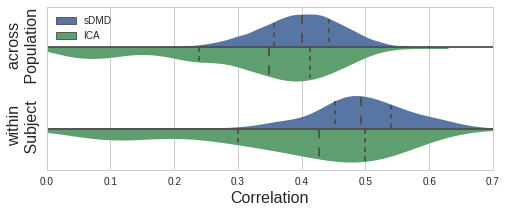

In [8]:

ica_pop=[];ica_sub=[]
dmd_pop=[];dmd_sub=[]
for u in ulist:
  try:
    with h5py.File('./sDMDvGICA/params/{:}_ica_best_spatial.h5'.format(u),'r') as hf:
      ica_pop.append(np.array(hf['Cpop_ica']))
      ica_sub.append(np.array(hf['Csub_ica']))
      dmd_pop.append(np.array(hf['Cpop_dmd']))
      dmd_sub.append(np.array(hf['Csub_dmd']))
  except:
    pass
dmd_pop=np.hstack(dmd_pop)
dmd_sub=np.hstack(dmd_sub)
ica_pop=np.hstack(ica_pop)
ica_sub=np.hstack(ica_sub)

dlist=[dmd_pop,dmd_sub,ica_pop,ica_sub]
dlabs=np.hstack([k*np.ones(len(d)) for k,d in enumerate(dlist)]).astype(int)
data=np.hstack(dlist)
is_ica=np.array(dlabs>=2).astype(int)
icatabs=np.array(['sDMD','ICA'])
is_ica=icatabs[is_ica]

dlt=['Across Population','Within Same Subject']
dlabtabs=np.array(dlt*2)
dlabs=dlabtabs[dlabs]

corlab='Correlation of DMD/ICA DMNs with gICA DMNs'

df=pd.DataFrame.from_dict({'popcompare':dlabs,corlab:data,'isICA':is_ica})

sns.set_style('whitegrid')
plt.close('all')
plt.figure(figsize=(8,3))
plt.plot([0,0.7],[0,0],c=[0.3,0.3,0.3])
plt.plot([0,0.7],[1,1],c=[0.3,0.3,0.3])
g=sns.violinplot(data=df,y='popcompare',x=corlab,hue='isICA',inner='quartile',split=True,legend_out=True,scale='width')
leg=g.axes.get_legend()
leg.set_title('');leg._loc=2

plt.xlim([0,0.7])
plt.yticks([0,1],['across   \n Population','within \n Subject'],rotation=90,va='center',size=16)
plt.ylabel('')
plt.xlabel('Correlation',size=16)

###SAVE
plt.savefig('./sDMDvGICA/Distributions.svg')
